In [1]:
# ===== Standard Libraries =====
import re
import warnings
import joblib
from collections import defaultdict

# ===== Scientific Computing =====
import numpy as np
import pandas as pd

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dot, Lambda
from tqdm.keras import TqdmCallback

# ===== Keras Tuner =====
import keras_tuner as kt

# ===== Scikit-learn =====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    average_precision_score,
    ndcg_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# ===== Pandas Display & Warnings =====
from pandas.errors import DtypeWarning
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=DtypeWarning)

	•	reviews_0-250.csv: Contains reviews for products indexed from 0 to 250.  
	•	reviews_250-500.csv: Contains reviews for products indexed from 250 to 500.  
	•	reviews_500-750.csv: Contains reviews for products indexed from 500 to 750.  
	•	reviews_750-1250.csv: Contains reviews for products indexed from 750 to 1250.  
	•	reviews_1250-end.csv: Contains reviews for products indexed from 1250 to the last product in the dataset.  

This segmentation is likely implemented to manage file sizes and facilitate easier data handling. Each file encompasses all reviews associated with the products within the specified index range.

In [2]:
pro_inf = pd.read_csv('../sephora_datasets/product_info.csv')
pro_inf_original = pro_inf.copy()
rew_1 = pd.read_csv('../sephora_datasets/reviews_0-250.csv')
rew_2 = pd.read_csv('../sephora_datasets/reviews_250-500.csv')
rew_3 = pd.read_csv('../sephora_datasets/reviews_500-750.csv')
rew_4 = pd.read_csv('../sephora_datasets/reviews_750-1250.csv')
rew_5 = pd.read_csv('../sephora_datasets/reviews_1250-end.csv')

files = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

df_reviews = pd.concat([rew_1, rew_2, rew_3, rew_4, rew_5], ignore_index=True, axis=0)
print("Combined shape:", df_reviews.shape)

Combined shape: (1094411, 19)


In [3]:
df_reviews_final = df_reviews[['product_id', 'author_id', 'rating']].copy()

In [4]:
df_reviews_final[['product_id', 'author_id']].nunique()

product_id      2351
author_id     578653
dtype: int64

#### remove dummy users

In [5]:
df_reviews_final = df_reviews_final.loc[~df_reviews_final['author_id'].str.contains(r'[a-zA-Z]', regex=True, na=False), :]

In [6]:
display(pro_inf.nunique())
print('************************** missing values:')
display(pro_inf.isnull().sum())

product_id            8494
product_name          8415
brand_id               304
brand_name             304
loves_count           7436
rating                4394
reviews               1556
size                  2055
variation_type           7
variation_value       2729
variation_desc         935
ingredients           6538
price_usd              298
value_price_usd        174
sale_price_usd          88
limited_edition          2
new                      2
online_only              2
out_of_stock             2
sephora_exclusive        2
highlights            4417
primary_category         9
secondary_category      41
tertiary_category      118
child_count             55
child_max_price        222
child_min_price        208
dtype: int64

************************** missing values:


product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

#### use later: variation_value, variation_desc, size.
#### use later (important): ingredients, highlights

## Item Matrix

In [7]:
df = pro_inf.copy()

In [8]:
core_columns_item = [
    'product_id', 'brand_id', 'price_usd', 'limited_edition', 'new',
    'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category',
    'child_count', 'variation_type'
]
columns_to_impute = ['rating', 'reviews', 'child_max_price', 'child_min_price']
columns_to_drop_item = [
    'product_name', 'brand_name', 'value_price_usd', 'sale_price_usd',
    'variation_value', 'variation_desc', 'tertiary_category', 'secondary_category'
]

In [9]:
df_cleaned = df.drop(columns=columns_to_drop_item)

In [10]:
brand_freq = df_cleaned['brand_id'].value_counts()
df_cleaned['brand_freq'] = df_cleaned['brand_id'].map(brand_freq)

# Log-scaling
# Helps reduce dominance of very high-frequency brands
df_cleaned['brand_freq_log'] = np.log1p(df_cleaned['brand_freq'])  # log(1 + x) to avoid log(0)

# Normalize (MinMax scaling to [0, 1])
scaler = MinMaxScaler()
df_cleaned['brand_freq_scaled'] = scaler.fit_transform(df_cleaned[['brand_freq_log']])

brand_freq_scaled_mapping = (
    df_cleaned[['brand_id', 'brand_freq_scaled']]
    .drop_duplicates(subset='brand_id')
    .set_index('brand_id')
    .squeeze()  # turns DataFrame → Series
    .to_dict()
)

In [11]:
for col in columns_to_impute:
    if col in df_cleaned.columns:
        if col in ['rating', 'child_max_price', 'child_min_price']:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(df_cleaned[col].median())
        elif col == 'reviews':
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)

# Fill missing categorical with "Unknown"
df_cleaned['primary_category'] = df_cleaned['primary_category'].fillna("Unknown")
#df_cleaned['secondary_category'] = df_cleaned['secondary_category'].fillna("Unknown")
df_cleaned['variation_type'] = df_cleaned['variation_type'].fillna("Unknown")

# One-hot encode variation_type and primary_category (few unique values)
df_encoded = pd.get_dummies(df_cleaned, columns=['variation_type', 'primary_category'], prefix=['var_type', 'pc'])

#### handle size column:

In [12]:
def normalize_size(text):
    """
    Convert the 'size' field to millilitres (mL), with oz converted to mL.
    Solids in g are left as-is. If parsing fails, returns np.nan.
    """
    if pd.isna(text):
        return np.nan
    
    text = str(text).strip().lower()
    
    # Match the first numeric value and a valid unit (ml, mL, g, oz), with optional spaces or separators
    # Handles: "1 oz / 30 ml", "1oz/30ml", ".5 oz / 15 mL", "2 x 0.5oz/15ml"
    m = re.search(r'(?<!\w)([\d.]+)\s*(oz|fl oz|ml|g|mL|grams?)(?!\w)', text)

    if not m:
        return np.nan

    val = m.group(1)
    unit = m.group(2)

    try:
        val = float(val)
    except ValueError:
        return np.nan

    unit = unit.lower()
    if unit in ('ml', 'mL'):
        return val
    elif unit in ('oz', 'fl oz'):
        return val * 29.5735  # Assume oz means fluid oz
    elif unit in ('g', 'gram', 'grams'):
        return val  # Leave solids in g
    else:
        return np.nan

In [13]:
# Apply to your DataFrame
df_encoded['size_ml'] = df_encoded['size'].apply(normalize_size)
df_encoded['size_ml_log'] = np.log1p(df_encoded['size_ml'])

df_encoded['size_missing'] = df_encoded['size'].isna().astype(int)
median_size_log = df_encoded['size_ml_log'].median()
df_encoded['size_ml_log'] = df_encoded['size_ml_log'].fillna(median_size_log).copy()
df_encoded = df_encoded.drop(['size_ml', 'size'], axis=1)

#### Handle Highlights and Ingredients

In [14]:
"""
import ast
from sklearn.feature_extraction.text import CountVectorizer

# Remove the “Product variation n:” labels and brackets
def clean_ing(row):
    if pd.isna(row):
        return ''
    # Turn the outer quotes into a python list then join
    try:
        lst = ast.literal_eval(row)
        # Some rows are nested lists, others are plain strings
        if isinstance(lst, list):
            row = ' '.join(lst)
    except Exception:
        pass
    # drop the "Product variation ..." chunks
    row = re.sub(r'Product variation \d+:', '', row, flags=re.I)
    return row.lower()

pro_inf['ingredients_clean'] = pro_inf['ingredients'].apply(clean_ing)

# Bag‑of‑words, keep top 500 ingredients
ing_vec = CountVectorizer(max_features=500, token_pattern=r'[A-Za-z]+').fit_transform(
    pro_inf['ingredients_clean']
)
ing_df = pd.DataFrame(ing_vec.toarray(),
                      columns=[f'ing_{w}' for w in CountVectorizer(max_features=500,
                                                                   token_pattern=r'[A-Za-z]+')
                               .fit(pro_inf['ingredients_clean'])
                               .get_feature_names_out()])

df_encoded = pd.concat([df_encoded, ing_df], axis=1)
"""
print()

In [15]:
"""
import ast

def parse_highlights(text):
    if pd.isna(text):
        return []
    try:
        return [tag.strip().lower() for tag in ast.literal_eval(text)]
    except Exception:
        return []

pro_inf['highlights_list'] = pro_inf['highlights'].apply(parse_highlights)

# build vocabulary
from itertools import chain
all_tags = sorted({tag for tags in pro_inf['highlights_list'] for tag in tags})
tag2col = {tag: idx for idx, tag in enumerate(all_tags)}

# multi‑hot matrix
high_mat = np.zeros((len(pro_inf), len(all_tags)), dtype=np.uint8)
for i, tags in enumerate(pro_inf['highlights_list']):
    high_mat[i, [tag2col[t] for t in tags]] = 1

high_df = pd.DataFrame(high_mat, columns=[f'high_{t}' for t in all_tags])
df_encoded = pd.concat([df_encoded, high_df], axis=1)
"""
print()

In [16]:
# Final item feature matrix
df_encoded = df_encoded.astype({col: 'int' for col in df_encoded.columns if df_encoded[col].dtype == 'bool'})
df_encoded = df_encoded.drop(['brand_id', 'brand_freq', 'brand_freq_log'], axis=1)

In [17]:
item_features_ordered = df_reviews_final[['product_id']].merge(df_encoded, on="product_id", how="left")
item_features_ordered = item_features_ordered.drop(['highlights', 'ingredients'], axis=1)

## User Matrix

In [18]:
print('************************ nunique_values:')
display(df_reviews.nunique())
print('************************ missing values:')
display(df_reviews.isnull().sum())
print('************************ shape:')
print(df_reviews.shape)

************************ nunique_values:


Unnamed: 0                  602130
author_id                   578653
rating                           5
is_recommended                   2
helpfulness                   3767
total_feedback_count           676
total_neg_feedback_count       259
total_pos_feedback_count       590
submission_time               5317
review_text                 969419
review_title                364105
skin_tone                       14
eye_color                        6
skin_type                        4
hair_color                       7
product_id                    2351
product_name                  2334
brand_name                     142
price_usd                      221
dtype: int64

************************ missing values:


Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              167988
helpfulness                 561592
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                   1444
review_title                310654
skin_tone                   170539
eye_color                   209628
skin_type                   111557
hair_color                  226768
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

************************ shape:
(1094411, 19)


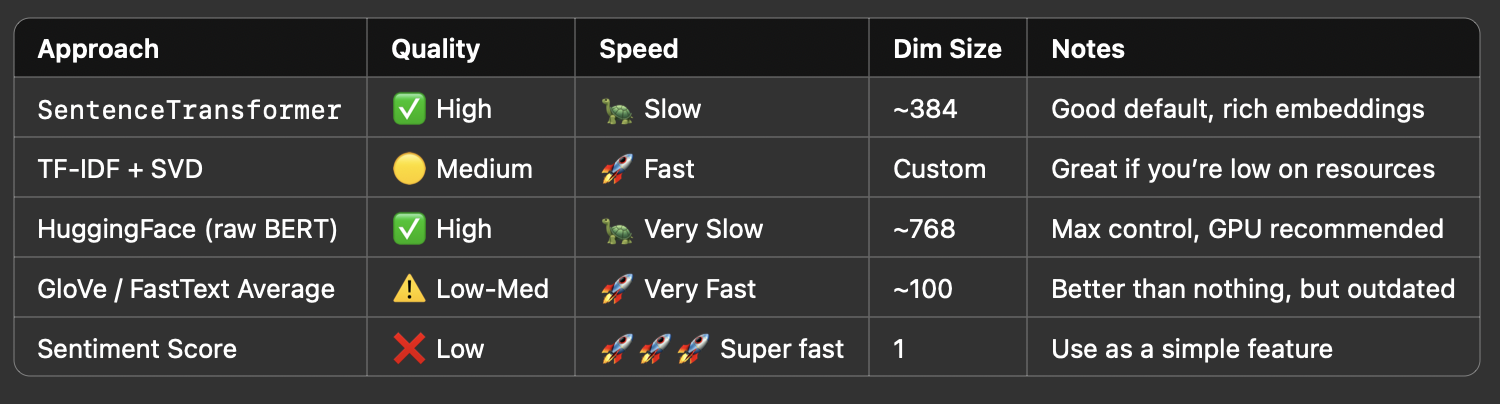

In [19]:
print('sentiment of the text')
"""
from textblob import TextBlob
# Fill missing texts just in case
df_reviews['review_text'] = df_reviews['review_text'].fillna("")

# Vectorized sentiment calculation
# Avoid lambda + apply and instead use a list comprehension
sentiments = [TextBlob(text).sentiment.polarity for text in df_reviews['review_text']]
df_reviews['sentiment'] = sentiments

# Group by user and take the mean sentiment
user_sentiment = df_reviews.groupby('user_id', sort=False)['sentiment'].mean().reset_index()
"""
print()

sentiment of the text



In [20]:
print('create sentence embeddings using sentence transformer')
"""
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Fill missing texts
df_reviews['review_text'] = df_reviews['review_text'].fillna("")

# Encode ALL reviews at once (much faster)
review_embeddings = model.encode(df_reviews['review_text'].tolist(), show_progress_bar=True)

# Add embeddings back to df_reviews
df_reviews['review_embedding'] = list(review_embeddings)

# Group by user_id and take mean of embeddings per user
user_text_embeddings = df_reviews.groupby('user_id')['review_embedding'].apply(
    lambda vecs: np.mean(vecs.tolist(), axis=0)
)

# Convert to dataframe for merging
user_text_embeddings_df = pd.DataFrame(user_text_embeddings.tolist(), index=user_text_embeddings.index)
user_text_embeddings_df.columns = [f'user_text_emb_{i}' for i in range(user_text_embeddings_df.shape[1])]
user_text_embeddings_df = user_text_embeddings_df.reset_index()
"""
print()

create sentence embeddings using sentence transformer



In [21]:
mask_no_feedback = (df_reviews['total_feedback_count'] == 0)
df_reviews.loc[mask_no_feedback, 'helpfulness'] = 0.0

for col in ['skin_tone', 'eye_color', 'skin_type', 'hair_color']:
    df_reviews[col] = df_reviews[col].fillna("Unknown")

user_agg = df_reviews.groupby("author_id").agg({
    "rating": ["mean", "count"],
    "is_recommended": "mean",
    "helpfulness": "mean",
    "skin_tone": "first",
    "skin_type": "first",
    "eye_color": "first",
    "hair_color": "first"
})
user_agg.columns = ['rating_avg', 'rating_count', 'recommend_ratio', 'helpfulness_avg',
                    'skin_tone', 'skin_type', 'eye_color', 'hair_color']
user_agg = user_agg.reset_index()

user_features = pd.get_dummies(user_agg, 
    columns=['skin_tone', 'skin_type', 'eye_color', 'hair_color'],
    prefix=['tone', 'type', 'eye', 'hair'])

global_recommend_avg = df_reviews["is_recommended"].mean()
user_features["recommend_missing"] = user_features["recommend_ratio"].isna().astype(int)
user_features["recommend_ratio"] = user_features["recommend_ratio"].fillna(global_recommend_avg)

user_features = user_features.astype({col: 'int' for col in user_features.columns if user_features[col].dtype == 'bool'})

#### Sentiment Score for review_text

In [22]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df_reviews['sentiment'] = df_reviews['review_text'].fillna("").apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

user_sentiment = df_reviews.groupby('author_id', sort=False)['sentiment'].mean().reset_index()

In [23]:
user_features = pd.merge(user_features, user_sentiment, on='author_id', how='left')

#### TF-IDF with Truncated Singular Value Decomposition (SVD-k)

In [24]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(df_reviews['review_text'].fillna(""))

In [25]:
svd = TruncatedSVD(n_components=128)
X_svd = svd.fit_transform(X_tfidf)

review_embeddings = pd.DataFrame(X_svd)

In [26]:
review_embeddings['author_id'] = df_reviews['author_id'].astype(str).values

user_text_embeddings_df = review_embeddings.groupby('author_id').mean().reset_index()
user_text_embeddings_df.columns = ['author_id'] + [f'user_text_emb_{i}' for i in range(X_svd.shape[1])]

In [27]:
user_features = user_features.merge(user_text_embeddings_df, on='author_id', how='left')

user_text_cols = [col for col in user_features.columns if col.startswith('user_text_emb_')]
user_features['text_emb_missing'] = user_features[user_text_cols[0]].isna().astype(int)
user_features[user_text_cols] = user_features[user_text_cols].fillna(user_features[user_text_cols].mean())

#user_text_embeddings_df['author_id'].nunique()
#user_features['author_id'].nunique() #some users dont have text, so that we have to fill these missing values after merging.

In [28]:
user_features_ordered = df_reviews_final[['author_id']].merge(user_features, on="author_id", how="left")

### Finalized User-Item DataFrames

In [29]:
user_features_ordered.head()

,author_id,rating_avg,rating_count,recommend_ratio,helpfulness_avg,tone_Unknown,tone_dark,tone_deep,tone_ebony,tone_fair,tone_fairLight,tone_light,tone_lightMedium,tone_medium,tone_mediumTan,tone_notSureST,tone_olive,tone_porcelain,tone_rich,tone_tan,type_Unknown,type_combination,type_dry,type_normal,type_oily,eye_Grey,eye_Unknown,eye_blue,eye_brown,eye_gray,eye_green,eye_hazel,hair_Unknown,hair_auburn,hair_black,hair_blonde,hair_brown,hair_brunette,hair_gray,hair_red,recommend_missing,sentiment,user_text_emb_0,user_text_emb_1,user_text_emb_2,user_text_emb_3,user_text_emb_4,user_text_emb_5,user_text_emb_6,user_text_emb_7,user_text_emb_8,user_text_emb_9,user_text_emb_10,user_text_emb_11,user_text_emb_12,user_text_emb_13,user_text_emb_14,user_text_emb_15,user_text_emb_16,user_text_emb_17,user_text_emb_18,user_text_emb_19,user_text_emb_20,user_text_emb_21,user_text_emb_22,user_text_emb_23,user_text_emb_24,user_text_emb_25,user_text_emb_26,user_text_emb_27,user_text_emb_28,user_text_emb_29,user_text_emb_30,user_text_emb_31,user_text_emb_32,user_text_emb_33,user_text_emb_34,user_text_emb_35,user_text_emb_36,user_text_emb_37,user_text_emb_38,user_text_emb_39,user_text_emb_40,user_text_emb_41,user_text_emb_42,user_text_emb_43,user_text_emb_44,user_text_emb_45,user_text_emb_46,user_text_emb_47,user_text_emb_48,user_text_emb_49,user_text_emb_50,user_text_emb_51,user_text_emb_52,user_text_emb_53,user_text_emb_54,user_text_emb_55,user_text_emb_56,user_text_emb_57,user_text_emb_58,user_text_emb_59,user_text_emb_60,user_text_emb_61,user_text_emb_62,user_text_emb_63,user_text_emb_64,user_text_emb_65,user_text_emb_66,user_text_emb_67,user_text_emb_68,user_text_emb_69,user_text_emb_70,user_text_emb_71,user_text_emb_72,user_text_emb_73,user_text_emb_74,user_text_emb_75,user_text_emb_76,user_text_emb_77,user_text_emb_78,user_text_emb_79,user_text_emb_80,user_text_emb_81,user_text_emb_82,user_text_emb_83,user_text_emb_84,user_text_emb_85,user_text_emb_86,user_text_emb_87,user_text_emb_88,user_text_emb_89,user_text_emb_90,user_text_emb_91,user_text_emb_92,user_text_emb_93,user_text_emb_94,user_text_emb_95,user_text_emb_96,user_text_emb_97,user_text_emb_98,user_text_emb_99,user_text_emb_100,user_text_emb_101,user_text_emb_102,user_text_emb_103,user_text_emb_104,user_text_emb_105,user_text_emb_106,user_text_emb_107,user_text_emb_108,user_text_emb_109,user_text_emb_110,user_text_emb_111,user_text_emb_112,user_text_emb_113,user_text_emb_114,user_text_emb_115,user_text_emb_116,user_text_emb_117,user_text_emb_118,user_text_emb_119,user_text_emb_120,user_text_emb_121,user_text_emb_122,user_text_emb_123,user_text_emb_124,user_text_emb_125,user_text_emb_126,user_text_emb_127,text_emb_missing
0,1741593524,5.0,1,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.9480,0.253524,0.001548,-0.000663,-0.000726,-0.002936,0.001417,-0.001304,-0.004229,0.00339,0.00505,0.000038,-0.002472,-0.001583,-0.001847,-0.00289,0.003138,0.003225,0.001298,0.000541,0.000216,0.00344,-0.00087,-0.000142,-0.002016,0.000737,0.000909,0.000014,-0.001207,-0.002348,-0.000192,-0.002833,0.001257,-0.000244,0.000462,-0.001889,0.000062,0.001557,-0.001393,0.001695,-0.000553,0.000999,0.000021,-0.000747,0.000253,0.000187,0.000112,0.000542,0.000496,0.000639,-0.000869,-0.001369,-0.001492,0.001228,0.000874,0.001072,0.000489,-0.001011,0.000649,-0.000086,-0.000667,-0.00019,-0.000098,0.00074,0.000315,0.000325,-0.000383,0.000131,0.000963,-0.0001,0.000239,0.000919,-0.000827,-0.000754,0.00053,-0.000255,0.000521,0.000185,-0.000482,0.000745,-0.000458,-0.000332,0.001032,-0.000882,0.000919,-0.001093,0.000277,0.000368,-0.000977,-0.000657,0.000143,-0.000603,0.000364,-0.000969,-0.000114,0.001085,-0.000739,-0.001073,-0.000373,0.00045,-0.000675,-0.000195,-0.000634,0.000112,0.000179,-0.00037,0.000011,0.000919,-0.000577,-0.000487,0.000025,0.000019,-0.000209,-0.000717,0.000132,0.000026,-0.000099,-0.000217,-0.00005,-0.000327,0.000139,-0.000767,0.000059,-0.000119,0.00012,-0.00023,0.000438,-

In [30]:
item_features_ordered.head()

,product_id,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price,brand_freq_scaled,var_type_Color,var_type_Formulation,var_type_Scent,var_type_Size,var_type_Size + Concentration,var_type_Size + Concentration + Formulation,var_type_Type,var_type_Unknown,pc_Bath & Body,pc_Fragrance,pc_Gifts,pc_Hair,pc_Makeup,pc_Men,pc_Mini Size,pc_Skincare,pc_Tools & Brushes,size_ml_log,size_missing
0,P504322,177,5.0000,1.0,19.0,0,0,1,0,0,0,32.0,28.0,0.606089,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,4.276338,0
1,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.077379,0
2,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.077379,0
3,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.077379,0
4,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.077379,0


## Final Touches on User & Item Datasets

In [31]:
num_user_features = user_features_ordered.shape[1] - 1
num_item_features = item_features_ordered.shape[1] - 1

u_s = 1  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items

print(num_user_features)
print(num_item_features)

170
32


In [32]:
item_train_df, item_test_df = train_test_split(item_features_ordered, train_size=0.80, shuffle=True, random_state=1)
user_train_df, user_test_df = train_test_split(user_features_ordered, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(df_reviews_final.rating.to_numpy(), train_size=0.80, shuffle=True, random_state=1)

user_test_ids = user_test_df.author_id.values

In [33]:
# 2. Detect binary columns and scale only non-binary
binary_user_cols = [col for col in user_train_df.columns[1:] if user_train_df[col].dropna().isin([0, 1]).all()]
user_cols_to_scale = [col for col in user_train_df.columns[1:] if col not in binary_user_cols]

binary_item_cols = [col for col in item_train_df.columns[1:] if item_train_df[col].dropna().isin([0, 1]).all()]
item_cols_to_scale = [col for col in item_train_df.columns[1:] if col not in binary_item_cols]

In [34]:
# 3. Scale only selected columns
scalerUser = StandardScaler()
user_train_df[user_cols_to_scale] = scalerUser.fit_transform(user_train_df[user_cols_to_scale])
user_test_df[user_cols_to_scale] = scalerUser.transform(user_test_df[user_cols_to_scale])

scalerItem = StandardScaler()
item_train_df[item_cols_to_scale] = scalerItem.fit_transform(item_train_df[item_cols_to_scale])
item_test_df[item_cols_to_scale] = scalerItem.transform(item_test_df[item_cols_to_scale])

In [35]:
# 4. Convert to numpy for model input
user_train = user_train_df.to_numpy()
user_test = user_test_df.to_numpy()
item_train = item_train_df.to_numpy()
item_test = item_test_df.to_numpy()

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train_scaled = scalerTarget.transform(y_train.reshape(-1, 1))
y_test_scaled = scalerTarget.transform(y_test.reshape(-1, 1))

## Starting Building the Model

In [36]:
num_outputs = 32
tf.random.set_seed(1)

user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs)
])

item_NN = tf.keras.models.Sequential([  
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_outputs)
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vu_normalized")(vu)


# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vm_normalized")(vm)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 170)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 32)        │     80,800 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32)        │     45,472 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vu_normalized       │ (None, 32)        │          0 │ sequential[0][0]  │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vm_normalized       │ (None, 32)        │          0 │ sequential_1[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ vu_normalized[0]… │
│                     │                   │            │ vm_normalized[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 126,272 (493.25 KB)

 Trainable params: 126,272 (493.25 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

tf.random.set_seed(1)

model.fit([tf.convert_to_tensor(user_train[:, u_s:], dtype=tf.float32), tf.convert_to_tensor(item_train[:, i_s:], dtype=tf.float32)], tf.convert_to_tensor(y_train_scaled, dtype=tf.float32), epochs=30)

Epoch 1/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 20s 707us/step - loss: 0.0949
Epoch 2/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 689us/step - loss: 0.0839
Epoch 3/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 689us/step - loss: 0.0828
Epoch 4/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 690us/step - loss: 0.0821
Epoch 5/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 20s 718us/step - loss: 0.0814
Epoch 6/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 683us/step - loss: 0.0807
Epoch 7/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 682us/step - loss: 0.0800
Epoch 8/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 681us/step - loss: 0.0793
Epoch 9/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 678us/step - loss: 0.0787
Epoch 10/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 683us/step - loss: 0.0780
Epoch 11/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 685us/step - loss: 0.0773
Epoch 12/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 702us/step - loss: 0.0768
Epoch 13/30
27359/27359 ━━━━━━━━━━━━━━━━━━━━ 19s 692us/step - loss: 0.0768
Epoch 14/30
27359/27359 ━━━━━━━━━━

### MAE, RMSE, MSE

In [38]:
# Apply the SAME scalers used on training data
model.evaluate(
    [tf.convert_to_tensor(user_test[:, u_s:], dtype=tf.float32),
     tf.convert_to_tensor(item_test[:, i_s:], dtype=tf.float32)],
    tf.convert_to_tensor(y_test_scaled, dtype=tf.float32)
)

6840/6840 ━━━━━━━━━━━━━━━━━━━━ 2s 286us/step - loss: 0.0913


0.09187496453523636

In [39]:
# Predict on scaled test data
y_pred_scaled = model.predict([
    tf.convert_to_tensor(user_test[:, u_s:], dtype=tf.float32),
    tf.convert_to_tensor(item_test[:, i_s:], dtype=tf.float32)
])

# Inverse transform predictions and true ratings back to original scale
y_pred_orig = scalerTarget.inverse_transform(y_pred_scaled)
y_test_orig = scalerTarget.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print("Test RMSE:", rmse)
print("Test MSE:", mse)
print("Test MAE:", mae)

6840/6840 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step
Test RMSE: 0.6062177216366911
Test MSE: 0.36749992602638065
Test MAE: 0.3305394364023141


MSE --> Scaled [-1 to 1 scale] --> 0.08037 --> Model loss during training/eval  
RMSE --> Original (1 to 5 scale) --> 0.567 --> Avg error in predicted rating  

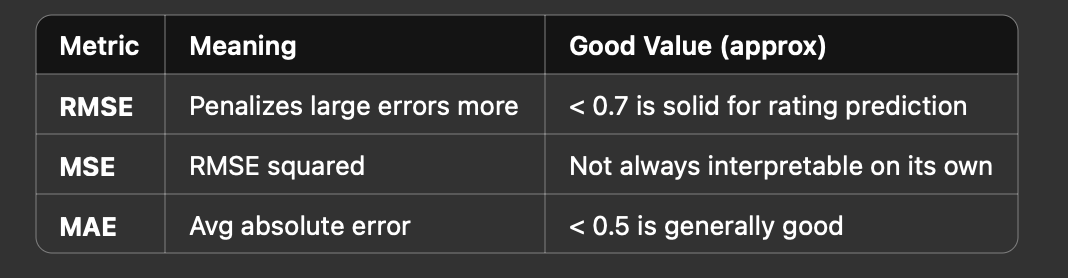

## avg_precision, avg_recall, avg_f1, avg_accuracy

In [40]:
"""
def precision_recall_f1_nn(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    '''
    Computes average precision, recall, F1, and accuracy across users.
    
    Parameters:
      - user_ids_test: array-like, user IDs corresponding to each test row.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold to decide if a rating is considered 'positive'
    
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    '''
    
    # Map predictions and true ratings to user IDs
    user_est_true = defaultdict(list)
    for uid, true_r, est in zip(user_ids_test, y_test_orig, y_pred_orig):
        user_est_true[uid].append((est, true_r))
    
    precisions = {}
    recalls = {}
    f1s = {}
    accuracies = {}
    
    for uid, ratings in user_est_true.items():
        # Create binary labels: 1 if rating >= threshold, else 0
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in ratings]
        y_pred_labels = [1 if (est >= threshold) else 0 for (est, _) in ratings]
        
        precisions[uid] = precision_score(y_true, y_pred_labels, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred_labels, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred_labels, zero_division=0)
        accuracies[uid] = accuracy_score(y_true, y_pred_labels)
    
    # Average the scores over all users
    avg_precision = sum(precisions.values()) / len(precisions) if precisions else 0.
    avg_recall = sum(recalls.values()) / len(recalls) if recalls else 0.
    avg_f1 = sum(f1s.values()) / len(f1s) if f1s else 0.
    avg_accuracy = sum(accuracies.values()) / len(accuracies) if accuracies else 0.
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy
"""
print()

In [41]:
"""
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig.reshape(-1),  # flatten if necessary
    y_pred_orig=y_pred_orig.reshape(-1),
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)
"""
print()

In [42]:
def precision_recall_f1_nn_vectorized(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    """
    Computes average precision, recall, F1, and accuracy across users in a vectorized manner.
    
    Parameters:
      - user_ids_test: array-like, user IDs for each test record.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold above which a rating is considered "positive".
      
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    """
    
    y_true_bin = (np.array(y_test_orig).flatten() >= threshold).astype(int)
    y_pred_bin = (np.array(y_pred_orig).flatten() >= threshold).astype(int)
    
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_true_bin,
        'pred': y_pred_bin
    })
    
    # Group by user and compute aggregated statistics:
    # - n_tp: number of true positives
    # - n_pred: total predicted positives
    # - n_true: total actual positives
    # - n_total: total number of ratings for the user
    # - n_correct: total correct predictions
    grouped = df.groupby('user').agg(
        n_tp = ('true', lambda x: np.sum(x * df.loc[x.index, 'pred'])),
        n_pred = ('pred', 'sum'),
        n_true = ('true', 'sum'),
        n_total = ('true', 'size'),
        n_correct = ('true', lambda x: np.sum(x == df.loc[x.index, 'pred']))
    )
    
    grouped['precision'] = grouped['n_tp'] / grouped['n_pred'].replace(0, np.nan)
    grouped['recall'] = grouped['n_tp'] / grouped['n_true'].replace(0, np.nan)
    grouped['accuracy'] = grouped['n_correct'] / grouped['n_total']
    grouped['f1'] = 2 * (grouped['precision'] * grouped['recall']) / (grouped['precision'] + grouped['recall'])
    
    grouped = grouped.fillna(0)
    
    avg_precision = grouped['precision'].mean()
    avg_recall = grouped['recall'].mean()
    avg_f1 = grouped['f1'].mean()
    avg_accuracy = grouped['accuracy'].mean()
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [43]:
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn_vectorized(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig, 
    y_pred_orig=y_pred_orig, 
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)

Average Precision: 0.7896979701719994
Average Recall: 0.7975554971021553
Average F1 Score: 0.7919384149938845
Average Accuracy: 0.9381690946665299


## Average Precision, nDCG@k, Average Precision@k

In [44]:
def measures_at_k_nn(user_ids_test, y_test_orig, y_pred_orig, k=10, threshold=3.5):
    """
    Computes average average_precision, precision@k, and nDCG@k across users
    for predictions from a two-tower model.
    
    Parameters:
      - user_ids_test: array-like of user IDs (one per test record)
      - y_test_orig: array-like of true ratings (original scale)
      - y_pred_orig: array-like of predicted ratings (original scale)
      - k: int, the number of top items to consider for "at k" metrics
      - threshold: float, the rating value at or above which an item is considered relevant
      
    Returns:
      avg_average_precision, avg_precision_at_k, avg_ndcg_at_k
    """
    user_ids_test = np.array(user_ids_test).flatten()
    y_test_orig = np.array(y_test_orig).flatten()
    y_pred_orig = np.array(y_pred_orig).flatten()
    
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_test_orig,
        'pred': y_pred_orig
    })
    
    df['true_bin'] = (df['true'] >= threshold).astype(int)
    df['pred_bin'] = (df['pred'] >= threshold).astype(int)
    
    user_est_true = df.groupby('user')
    
    average_precisions = {}
    precisions_at_k = {}
    ndcgs_at_k = {}
    
    for uid, group in user_est_true:
        # Convert each user's group to a list of tuples: (predicted rating, true rating, binary true)
        # Sort the user’s items by predicted rating in descending order.
        sorted_group = group.sort_values(by='pred', ascending=False)
        y_true = sorted_group['true_bin'].tolist()
        y_pred = sorted_group['pred_bin'].tolist()
        
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        # Compute average precision over the full ranked list if the user has any relevant items.
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(sorted_group['true_bin'], sorted_group['pred_bin'])
        else:
            average_precisions[uid] = 0.0
        
        # Compute precision at k.
        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        # For nDCG, raw ratings are needed and consider the ranking.
        # nDCG expects input arrays of shape (1, n); convert the sorted true and predicted ratings.
        if len(sorted_group) > 1:
            true_rel = np.asarray(sorted_group['true'].tolist()).reshape(1, -1)
            pred_rel = np.asarray(sorted_group['pred'].tolist()).reshape(1, -1)
            ndcgs_at_k[uid] = ndcg_score(true_rel, pred_rel, k=k)
        else:
            # If there's only one item, then return a simple binary match.
            ndcgs_at_k[uid] = 1.0 if (y_true[0] == y_pred[0] and y_true[0] == 1) else 0.0
    
    # Average metrics across all users.
    avg_average_precision = np.mean(list(average_precisions.values()))
    avg_precision_at_k = np.mean(list(precisions_at_k.values()))
    avg_ndcg_at_k = np.mean(list(ndcgs_at_k.values()))
    
    return avg_average_precision, avg_precision_at_k, avg_ndcg_at_k

In [45]:
avg_ap, avg_prec_k, avg_ndcg_k = measures_at_k_nn(user_test_ids, y_test_orig, y_pred_orig, k=10, threshold=3.5)
print("Avg. Average Precision:", avg_ap)
print("Avg. Precision@10:", avg_prec_k)
print("Avg. nDCG@10:", avg_ndcg_k)

Avg. Average Precision: 0.8148645891097434
Avg. Precision@10: 0.7897164914774283
Avg. nDCG@10: 0.8180236654371165


##### adding textual features didn't help.

# hyperparameter tuning

In [98]:
# ──────────────────────────────────────────────────────────────
# 1.  Train / Val / Test split  (80 / 16 / 4 overall)
# ──────────────────────────────────────────────────────────────
item_train_full, item_test_df = train_test_split(
    item_features_ordered, train_size=0.80, random_state=1, shuffle=True)
user_train_full, user_test_df = train_test_split(
    user_features_ordered, train_size=0.80, random_state=1, shuffle=True)
y_train_full, y_test = train_test_split(
    df_reviews_final.rating.to_numpy(), train_size=0.80, random_state=1, shuffle=True)

item_train_df, item_val_df = train_test_split(
    item_train_full, train_size=0.80, random_state=1, shuffle=True)
user_train_df, user_val_df = train_test_split(
    user_train_full, train_size=0.80, random_state=1, shuffle=True)
y_train, y_val = train_test_split(
    y_train_full, train_size=0.80, random_state=1, shuffle=True)

user_test_ids = user_test_df.author_id.values

In [99]:
# ──────────────────────────────────────────────────────────────
# 2.  Scale non‑binary columns
# ──────────────────────────────────────────────────────────────
def detect_binary(df):
    return [c for c in df.columns[1:] if df[c].dropna().isin([0, 1]).all()]

binary_user = detect_binary(user_train_df)
binary_item = detect_binary(item_train_df)

user_cols_to_scale = [c for c in user_train_df.columns[1:] if c not in binary_user]
item_cols_to_scale = [c for c in item_train_df.columns[1:] if c not in binary_item]

scalerUser = StandardScaler().fit(user_train_df[user_cols_to_scale])
scalerItem = StandardScaler().fit(item_train_df[item_cols_to_scale])

for _df in [user_train_df, user_val_df, user_test_df]:
    _df[user_cols_to_scale] = scalerUser.transform(_df[user_cols_to_scale])

for _df in [item_train_df, item_val_df, item_test_df]:
    _df[item_cols_to_scale] = scalerItem.transform(_df[item_cols_to_scale])

item_train_df_cols = item_train_df.columns
item_train_df_cols = [col for col in item_train_df_cols if col != 'product_id']

user_train_df_cols = user_train_df.columns
user_train_df_cols = [col for col in user_train_df_cols if col != 'author_id']

# target scaler
scalerTarget = MinMaxScaler(feature_range=(-1, 1)).fit(y_train.reshape(-1, 1))

In [100]:
# drop non‑numeric IDs and convert to float32
user_train = user_train_df.drop(columns="author_id").to_numpy(np.float32)
user_val   = user_val_df.drop(columns="author_id").to_numpy(np.float32)
user_test  = user_test_df.drop(columns="author_id").to_numpy(np.float32)

item_train = item_train_df.drop(columns="product_id").to_numpy(np.float32)
item_val   = item_val_df.drop(columns="product_id").to_numpy(np.float32)
item_test  = item_test_df.drop(columns="product_id").to_numpy(np.float32)

y_train_scaled = scalerTarget.transform(y_train.reshape(-1, 1)).astype(np.float32)
y_val_scaled   = scalerTarget.transform(y_val.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = scalerTarget.transform(y_test.reshape(-1, 1)).astype(np.float32)
y_train_full_scaled = scalerTarget.transform(y_train_full.reshape(-1, 1)).astype(np.float32)

NUM_USER_FEATURES = user_train.shape[1]          # IDs already dropped → no -1
NUM_ITEM_FEATURES = item_train.shape[1]

In [49]:
# ──────────────────────────────────────────────────────────────
# 3.  Model‑building function   (search space includes baseline)
# ──────────────────────────────────────────────────────────────
def build_two_tower(hp: kt.HyperParameters) -> keras.Model:
    embed_dim = hp.Int("embedding_dim", 16, 128, step=16, default=32)

    def tower(prefix: str, n_features: int) -> keras.Sequential:
        seq = keras.Sequential(name=f"{prefix}_tower")
        # for reproducibility make the *baseline* (256,128) reachable
        units1 = hp.Int(f"{prefix}_dense1", 64, 512, step=64, default=256)
        units2 = hp.Int(f"{prefix}_dense2", 32, 256, step=32, default=128)
        seq.add(Dense(units1, activation="relu"))
        seq.add(Dense(units2, activation="relu"))
        seq.add(Dense(embed_dim))
        return seq

    user_in = Input((NUM_USER_FEATURES,), name="user_in")
    item_in = Input((NUM_ITEM_FEATURES,), name="item_in")

    vu = tower("u", NUM_USER_FEATURES)(user_in)
    vm = tower("i", NUM_ITEM_FEATURES)(item_in)

    vu = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(vu)
    vm = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(vm)
    dot = Dot(axes=1)([vu, vm])
    out = Lambda(lambda t: tf.cast(t, tf.float32))(dot)   # mixed‑precision safe

    model = keras.Model([user_in, item_in], out)
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log", default=1e-3)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

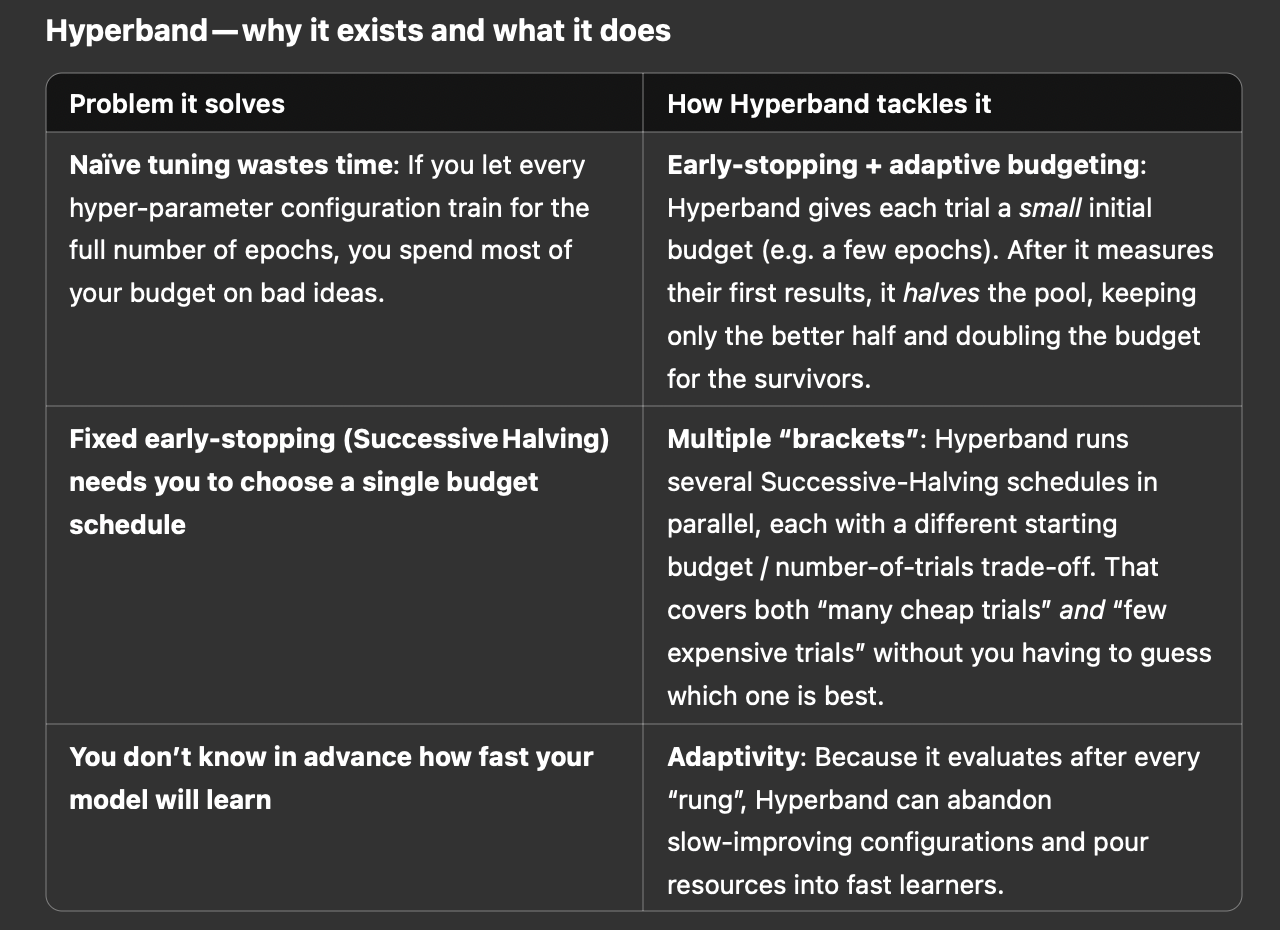

In [50]:
# ──────────────────────────────────────────────────────────────
# 4.  Hyper‑parameter tuning  (Hyperband)
# ──────────────────────────────────────────────────────────────
tuner = kt.Hyperband(
    build_two_tower,
    objective=kt.Objective("val_rmse", "min"),
    max_epochs=30,
    factor=3,
    directory="kt_tuner_v2",
    project_name="two_tower_hb",
    overwrite=True
)

stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

tuner.search(
    x=[user_train, item_train],
    y=y_train_scaled,
    validation_data=([user_val, item_val], y_val_scaled),
    batch_size=256,
    callbacks=[stop],
    verbose=2
)

best_hp = tuner.get_best_hyperparameters(1)[0]

Trial 90 Complete [00h 00m 43s]
val_rmse: 0.28817448019981384

Best val_rmse So Far: 0.28673288226127625
Total elapsed time: 00h 28m 53s


In [51]:
# ──────────────────────────────────────────────────────────────
# 5.  *** FINAL FIT on full 80 % (train + val) ***
# ──────────────────────────────────────────────────────────────
final_model = build_two_tower(best_hp)
final_model.fit(
    [np.concatenate([user_train, user_val]), np.concatenate([item_train, item_val])],
    np.concatenate([y_train_scaled, y_val_scaled]),
    epochs=30,
    batch_size=256,
    callbacks=[stop],
    verbose=2
)

Epoch 1/30
3420/3420 - 4s - 1ms/step - loss: 0.0903 - rmse: 0.3005
Epoch 2/30


/opt/anaconda3/envs/webmining/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse
  current = self.get_monitor_value(logs)


3420/3420 - 4s - 1ms/step - loss: 0.0836 - rmse: 0.2891
Epoch 3/30
3420/3420 - 4s - 1ms/step - loss: 0.0826 - rmse: 0.2875
Epoch 4/30
3420/3420 - 4s - 1ms/step - loss: 0.0820 - rmse: 0.2863
Epoch 5/30
3420/3420 - 4s - 1ms/step - loss: 0.0814 - rmse: 0.2853
Epoch 6/30
3420/3420 - 4s - 1ms/step - loss: 0.0809 - rmse: 0.2845
Epoch 7/30
3420/3420 - 4s - 1ms/step - loss: 0.0805 - rmse: 0.2837
Epoch 8/30
3420/3420 - 4s - 1ms/step - loss: 0.0801 - rmse: 0.2830
Epoch 9/30
3420/3420 - 4s - 1ms/step - loss: 0.0797 - rmse: 0.2823
Epoch 10/30
3420/3420 - 17s - 5ms/step - loss: 0.0794 - rmse: 0.2817
Epoch 11/30
3420/3420 - 4s - 1ms/step - loss: 0.0791 - rmse: 0.2813
Epoch 12/30
3420/3420 - 4s - 1ms/step - loss: 0.0788 - rmse: 0.2808
Epoch 13/30
3420/3420 - 4s - 1ms/step - loss: 0.0786 - rmse: 0.2803
Epoch 14/30
3420/3420 - 4s - 1ms/step - loss: 0.0783 - rmse: 0.2799
Epoch 15/30
3420/3420 - 4s - 1ms/step - loss: 0.0781 - rmse: 0.2794
Epoch 16/30
3420/3420 - 4s - 1ms/step - loss: 0.0779 - rmse: 0.279

In [52]:
# ──────────────────────────────────────────────────────────────
# 6.  Evaluation on untouched 20 % test split
# ──────────────────────────────────────────────────────────────
scaled_rmse = final_model.evaluate(
    [user_test, item_test], y_test_scaled, verbose=0
)[1]
y_pred_scaled = final_model.predict([user_test, item_test], verbose=0)
y_pred_orig = scalerTarget.inverse_transform(y_pred_scaled)
y_test_orig = scalerTarget.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mse  = mean_squared_error(y_test_orig, y_pred_orig)
mae  = mean_absolute_error(y_test_orig, y_pred_orig)

print("\n────────  Final results on TEST  ────────")
print(f"Scaled RMSE : {scaled_rmse: .4f}")
print(f"Orig  RMSE  : {rmse: .4f}")
print(f"Orig  MSE   : {mse: .4f}")
print(f"Orig  MAE   : {mae: .4f}")

# --- ranking metrics ----------------------------------------
prec, rec, f1, acc = precision_recall_f1_nn_vectorized(
    user_test_ids, y_test_orig, y_pred_orig, threshold=3.5)
map_, p10, ndcg10 = measures_at_k_nn(
    user_test_ids, y_test_orig, y_pred_orig, k=10, threshold=3.5)

print(f"PRF/A  : {prec:.3f} / {rec:.3f} / {f1:.3f} / {acc:.3f}")
print(f"MAP / P@10 / nDCG@10 : {map_:.3f} / {p10:.3f} / {ndcg10:.3f}")


────────  Final results on TEST  ────────
Scaled RMSE :  0.2928
Orig  RMSE  :  0.5856
Orig  MSE   :  0.3429
Orig  MAE   :  0.3167
PRF/A  : 0.791 / 0.799 / 0.794 / 0.941
MAP / P@10 / nDCG@10 : 0.815 / 0.791 / 0.819


## Find the Most Similar Products

In [106]:
item_train_df_cols[:5] #column order used in training

['loves_count', 'rating', 'reviews', 'price_usd', 'limited_edition']

In [107]:
user_train_df_cols[:5] #column order used in training

['rating_avg',
 'rating_count',
 'recommend_ratio',
 'helpfulness_avg',
 'tone_Unknown']

In [108]:
# 1. Drop duplicate product_ids
item_features_unique = item_features_ordered.drop_duplicates(subset="product_id", keep="first")

# 2. Separate numeric and binary columns
prod_ids = item_features_unique["product_id"].to_numpy()
item_numeric = item_features_unique.drop(columns=["product_id"])

if hasattr(scalerItem, "feature_names_in_"):
    cols_to_scale = list(scalerItem.feature_names_in_)
else:
    raise ValueError("scalerItem must include feature_names_in_")

# 3. Apply scaling
scaled_numeric = scalerItem.transform(item_numeric[cols_to_scale])
unchanged_cols = [c for c in item_numeric.columns if c not in cols_to_scale]
unchanged_part = item_numeric[unchanged_cols]

scaled_numeric_df = pd.DataFrame(
    scaled_numeric,
    columns=cols_to_scale,
    index=item_numeric.index
)

item_matrix_scaled_df = pd.concat([scaled_numeric_df, unchanged_part], axis=1)
item_matrix_scaled_df = item_matrix_scaled_df[item_train_df_cols]
item_matrix_scaled = item_matrix_scaled_df.to_numpy(dtype=np.float32)

# 5. Build item embedding extractor
item_in = final_model.inputs[1]
vm_layer = final_model.get_layer("lambda_4").output
item_encoder = keras.Model(inputs=item_in, outputs=vm_layer)

# 6. Extract item embeddings
vm_all = item_encoder.predict(item_matrix_scaled, batch_size=1024, verbose=0)

# Nearest-neighbor search using vectorized L2 squared distance
def most_similar_items(query_prod_id, top_k=5):
    try:
        q_idx = np.where(prod_ids == query_prod_id)[0][0]
    except IndexError:
        raise ValueError(f"Product ID '{query_prod_id}' not found!")

    q_vec = vm_all[q_idx]  # shape (embed_dim,)
    dists = (np.sum(vm_all**2, axis=1) +
             np.sum(q_vec**2) -
             2 * vm_all @ q_vec)

    # Get top_k closest items (excluding the query item itself)
    nearest = np.argsort(dists)
    nearest = nearest[nearest != q_idx]  # exclude self

    # ensure unique product_ids in result (just in case)
    seen = set()
    unique_nearest = []
    for idx in nearest:
        pid = prod_ids[idx]
        if pid not in seen:
            seen.add(pid)
            unique_nearest.append(idx)
        if len(unique_nearest) == top_k:
            break

    return pd.DataFrame({
        "product_id": prod_ids[unique_nearest],
        "sq_distance": dists[unique_nearest]
    })

In [109]:
query_id = "P420652"
similar_items = most_similar_items(query_id, top_k=10)
merged = pd.merge(similar_items,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')

display(merged)

,product_id,sq_distance,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P427417,0.001543,Niacinamide 10% + Zinc 1% Oil Control Serum,The Ordinary,6.00,0,0,Skincare,Treatments
1,P443842,0.002064,Retinol Anti-Aging Serum,The INKEY List,12.99,0,0,Skincare,Treatments
2,P458917,0.002300,Water-Lock Moisturizer with Skin-Smoothing Pep...,Tata Harper,68.00,0,0,Skincare,Moisturizers
3,P500687,0.002441,Keep It Clean Hydrating Gel Cleanser with Cera...,iNNBEAUTY PROJECT,26.00,0,0,Skincare,Cleansers
4,P479330,0.002679,Water Sleeping Mask with Squalane,LANEIGE,32.00,0,0,Skincare,Masks
5,P466123,0.002727,Watermelon Glow Niacinamide Dew Drops,Glow Recipe,35.00,0,0,Skincare,Treatments
6,P471003,0.002873,Squalane + BHA Pore-Minimizing Toner,Biossance,30.00,0,0,Skincare,Cleansers
7,P504218,0.002963,Dewy Cleanse + Hydrate Duo,Tatcha,27.00,0,0,Skincare,Value & Gift Sets
8,P443358,0.002975,Intensive Moisture Balance Moisturizer,Dermalogica,47.00,0,0,Skincare,Moisturizers
9,P422905,0.003123,Moisturizing Eye Bomb with Squalane,belif,48.00,0,0,Skincare,Eye Care


In [55]:
#final_model.save("final_two_tower_model.keras")

In [56]:
#final_model.save("final_two_tower_model.h5")

In [57]:
#from tensorflow.keras.models import load_model

#final_model = load_model("final_two_tower_model.keras", safe_mode=False)

## Prediction for a new user

In [67]:
# Column order for inference
USER_COLS = user_features_ordered.drop('author_id', axis=1).columns.tolist()
joblib.dump(USER_COLS, "user_feature_cols.pkl")

# Text pipeline
joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(svd,   "svd.pkl")

# Any numeric defaults you filled with training means
GLOBAL_REC_AVG   = df_reviews["is_recommended"].mean()       # e.g. 0.82
text_cols = user_features.columns[user_features.columns.str.startswith("user_text_emb_")]

MEAN_TEXT_EMB128 = user_features.loc[:, text_cols].mean().values     # shape (128,)

joblib.dump({"rec_avg": GLOBAL_REC_AVG,
             "text_emb_mean": MEAN_TEXT_EMB128}, "defaults.pkl")

joblib.dump(scalerUser,   "scaler_user.pkl")
joblib.dump(scalerItem,   "scaler_item.pkl")
joblib.dump(scalerTarget, "scaler_target.pkl")

['scaler_target.pkl']

In [111]:
# ----- load artefacts --------------------------------------------------------
USER_COLS      = joblib.load("user_feature_cols.pkl")
tfidf          = joblib.load("tfidf.pkl")
svd            = joblib.load("svd.pkl")
DEFAULTS       = joblib.load("defaults.pkl")
scalerUser     = joblib.load("scaler_user.pkl")
scalerItem     = joblib.load("scaler_item.pkl")
scalerTarget   = joblib.load("scaler_target.pkl")
analyzer       = SentimentIntensityAnalyzer()
MEAN_TEXT_EMB  = DEFAULTS["text_emb_mean"]

# -----------------------------------------------------------------------------    
def build_user_vector(raw_reviews: pd.DataFrame) -> np.ndarray:
    """
    raw_reviews: one row per review.  Expected columns:
      rating, is_recommended, helpfulness, review_text,
      skin_tone, skin_type, eye_color, hair_color
    Returns np.array shaped (1, num_user_features)
    """

    if raw_reviews.empty:
        raw_reviews = pd.DataFrame([{
            "rating": np.nan,
            "is_recommended": np.nan,
            "helpfulness": np.nan,
            "review_text": np.nan,
            "skin_tone": "Unknown",
            "skin_type": "Unknown",
            "eye_color": "Unknown",
            "hair_color": "Unknown"
        }])

    # ---------- aggregate numeric signals ------------------------------------
    agg = raw_reviews.agg({
        "rating"         : ["mean", "count"],
        "is_recommended" : "mean",
        "helpfulness"    : "mean"
    })

    row = {
        "rating_avg"      : agg.loc["mean",  ("rating")],
        "rating_count"    : agg.loc["count", ("rating")],
        "recommend_ratio" : agg.loc["mean",  ("is_recommended")],
        "helpfulness_avg" : agg.loc["mean",  ("helpfulness")]
    }

    if pd.isna(row["recommend_ratio"]):
        row["recommend_missing"] = 1
        row["recommend_ratio"]   = DEFAULTS["rec_avg"]
    else:
        row["recommend_missing"] = 0

    # ---------- sentiment -----------------------------------------------------
    raw_reviews["sentiment"] = raw_reviews["review_text"].fillna("")\
                                 .map(lambda t: analyzer.polarity_scores(t)["compound"])
    row["sentiment"] = raw_reviews["sentiment"].mean()

    # ---------- demographics (one-hot, same dummies as training) -------------
    for c in ["skin_tone", "skin_type", "eye_color", "hair_color"]:
        raw_reviews[c] = raw_reviews[c].fillna("Unknown")

    demo = pd.get_dummies(raw_reviews[["skin_tone","skin_type",
                                       "eye_color","hair_color"]].iloc[[0]],
                          columns = ["skin_tone","skin_type","eye_color","hair_color"],
                          prefix  = ["tone","type","eye","hair"])

    # ---------- text embeddings (TF-IDF → SVD → mean vector) -----------------
    if raw_reviews["review_text"].notna().any():
        emb = svd.transform(tfidf.transform(raw_reviews["review_text"].fillna("")))
        text_vec = emb.mean(axis=0)
        text_missing = 0
    else:
        text_vec     = MEAN_TEXT_EMB
        text_missing = 1

    row.update({f"user_text_emb_{i}": text_vec[i] for i in range(len(text_vec))})
    row["text_emb_missing"] = text_missing

    # ---------- assemble full feature row ------------------------------------
    user_df = pd.DataFrame([row]).join(demo, how="left")
    user_df = user_df.reindex(columns=USER_COLS, fill_value=0)

    # Apply scaling to only the numerical columns scalerUser was trained on
    if hasattr(scalerUser, "feature_names_in_"):
        cols_to_scale = list(scalerUser.feature_names_in_)
    else:
        raise ValueError("scalerUser must have 'feature_names_in_' set.")

    user_df.loc[:, cols_to_scale] = scalerUser.transform(user_df[cols_to_scale])

    # Convert one-hot columns from bool to int
    bool_cols = user_df.columns[user_df.dtypes == bool]
    user_df[bool_cols] = user_df[bool_cols].astype(int)

    return user_df

In [112]:
# 1.  New user *with* a few reviews
new_reviews = pd.DataFrame({
    "rating"        : [5, 4],
    "is_recommended": [1, 1],
    "helpfulness"   : [3, 0],
    "review_text"   : ["Loved it – great texture!",
                       "Pretty good but expensive"],
    "skin_tone"     : ["medium"] * 2,
    "skin_type"     : ["oily"] * 2,
    "eye_color"     : ["brown"] * 2,
    "hair_color"    : ["black"] * 2
})
u_vec = build_user_vector(new_reviews)

# 2.  Totally cold-start user (no reviews, only profile info)
cold_start = pd.DataFrame([{
    "rating": np.nan,
    "is_recommended": np.nan,
    "helpfulness": np.nan,
    "review_text": np.nan,
    "skin_tone": "fair",
    "skin_type": "dry",
    "eye_color": "blue",
    "hair_color": "blonde"
}])
u_vec_reviewed      = build_user_vector(new_reviews)      # user with reviews
u_vec_profile_only  = build_user_vector(cold_start)       # profile-only user
u_vec_anonymous     = build_user_vector(pd.DataFrame())   # anonymous fallback

In [116]:
#u_vec_reviewed
#u_vec_reviewed[user_train_df_cols]

In [117]:
# ------------------------------------------------------------------
# 2.  Prepare the full item-feature matrix (shape: n_items × num_item_features)
item_features_no_dup = item_features_ordered.drop_duplicates(keep='first')
item_ids  = item_features_no_dup["product_id"].values          # keep for later
item_mat  = item_features_no_dup.drop("product_id", axis=1) \
                                   .to_numpy(dtype=np.float32)

# ------------------------------------------------------------------
# 3.  Predict in batches (fast + avoids memory blow-up)
BATCH   = 4096                      # tune to your GPU / RAM
n_items = item_mat.shape[0]

scores = []
for start in range(0, n_items, BATCH):
    end   = start + BATCH
    batch_item = item_mat[start:end]

    # repeat the single user-vector to match this batch size
    batch_user = np.repeat(u_vec_reviewed.to_numpy(dtype=np.float32), repeats=len(batch_item), axis=0)

    batch_scores = final_model.predict([batch_user, batch_item],
                                 batch_size=len(batch_item),
                                 verbose=0).reshape(-1)
    scores.append(batch_scores)

scores = np.concatenate(scores)
scores_raw = scalerTarget.inverse_transform(scores.reshape(-1, 1)).ravel()

# 5.  Build a ranked table
recommendations = pd.DataFrame({
    "product_id": item_ids,
    "pred_score": scores_raw  # now in original rating scale
}).sort_values("pred_score", ascending=False).reset_index(drop=True)

display(recommendations.head(10))

,product_id,pred_score
0,P505210,4.688282
1,P505381,4.687992
2,P505378,4.684525
3,P505209,4.676841
4,P503906,4.657731
5,P504985,4.657061
6,P469829,4.655882
7,P505131,4.654763
8,P505160,4.653778
9,P505133,4.653304


In [118]:
merged_preds = pd.merge(recommendations,
                  pro_inf[['product_id', 'product_name', 'brand_name', 'price_usd', 
                           'limited_edition', 'online_only', 'primary_category', 'secondary_category']],
                  on='product_id',
                  how='left')
merged_preds.head()

,product_id,pred_score,product_name,brand_name,price_usd,limited_edition,online_only,primary_category,secondary_category
0,P505210,4.688282,"Barrier Culture Cleanser Pre-, Pro- & Postbiot...",The Nue Co.,42.0,0,1,Skincare,Cleansers
1,P505381,4.687992,Multi Action Clear Gentle Daily Brightening & ...,StriVectin,39.0,0,0,Skincare,Cleansers
2,P505378,4.684525,Multi Action Clear Acne Control 30-Day Trial Kit,StriVectin,39.0,0,0,Skincare,Value & Gift Sets
3,P505209,4.676841,Barrier Culture Moisturizer with Niacinamide &...,The Nue Co.,65.0,0,1,Skincare,Moisturizers
4,P503906,4.657731,DRx SpectraLite LED EyeCare Max Pro,Dr. Dennis Gross Skincare,199.0,0,0,Skincare,High Tech Tools
